<a href="https://www.kaggle.com/code/itsnahm/insurance-claim-segmentation?scriptVersionId=117020050" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Hi!
This is my third times notebook! After learn about EDA for data analysis and machine learning, I'll learn and practice customer segmentation as I've learned before. I've learned from [DQLab](http://dqlab.id) in Bahasa. Hopefully I could more understand about what and how customer segmentation in Data Science!

In this case, I'll try to segmentation with Machine Learning K-Prototypes.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/insurance-claim-analysis-demographic-and-health/insurance_data.csv


# Libraries and Dataset Preparation

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

from kmodes.kmodes import KModes
from kmodes.kprototypes import KPrototypes

import pickle
from pathlib import Path

# Dataset Indentification

In [3]:
df = pd.read_csv("/kaggle/input/insurance-claim-analysis-demographic-and-health/insurance_data.csv")

In [4]:
df

,index,PatientID,age,gender,bmi,bloodpressure,diabetic,children,smoker,region,claim
0,0,1,39.0,male,23.2,91,Yes,0,No,southeast,1121.87
1,1,2,24.0,male,30.1,87,No,0,No,southeast,1131.51
2,2,3,NaN,male,33.3,82,Yes,0,No,southeast,1135.94
3,3,4,NaN,male,33.7,80,No,0,No,northwest,1136.40
4,4,5,NaN,male,34.1,100,No,0,No,northwest,1137.01
...,...,...,...,...,...,...,...,...,...,...,...
1335,1335,1336,44.0,female,35.5,88,Yes,0,Yes,northwest,55135.40
1336,1336,1337,59.0,female,38.1,120,No,1,Yes,northeast,58571.07
1337,1337,1338,30.0,male,34.5,91,Yes,3,Yes,northwest,60021.40
1338,1338,1339,37.0,male,30.4,106,No,0,Yes,southeast,62592.87


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1340 entries, 0 to 1339
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          1340 non-null   int64  
 1   PatientID      1340 non-null   int64  
 2   age            1335 non-null   float64
 3   gender         1340 non-null   object 
 4   bmi            1340 non-null   float64
 5   bloodpressure  1340 non-null   int64  
 6   diabetic       1340 non-null   object 
 7   children       1340 non-null   int64  
 8   smoker         1340 non-null   object 
 9   region         1337 non-null   object 
 10  claim          1340 non-null   float64
dtypes: float64(3), int64(4), object(4)
memory usage: 115.3+ KB


In [6]:
df.shape

(1340, 11)

In [7]:
df.isna().sum()

index            0
PatientID        0
age              5
gender           0
bmi              0
bloodpressure    0
diabetic         0
children         0
smoker           0
region           3
claim            0
dtype: int64

There are missing values in age and region columns.

In [8]:
df.nunique()

index            1340
PatientID        1340
age                43
gender              2
bmi               275
bloodpressure      61
diabetic            2
children            6
smoker              2
region              4
claim            1337
dtype: int64

index and PatientID columns have unique values as much as amount of data.

In [9]:
df.duplicated().sum()

0

There is no duplicate data in dataset insurance.

# Data Preprocessing

Since index and PatientID have too much unique values, I'll drop it.

In [10]:
df = df.drop(['index','PatientID'], axis=1)
df.shape

(1340, 9)

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='age'>

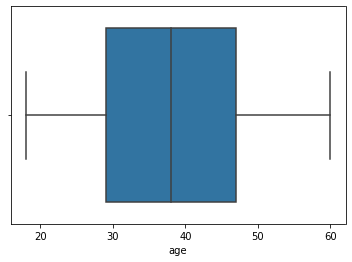

In [11]:
sns.boxplot(df['age'])

Fill missing values in age column with mean because there is no outliers in data there.

In [12]:
df['age'] = df['age'].fillna(df['age'].mean())

Fill missing values in region column with the most amount of unique value in data.

In [13]:
df['region'] = df['region'].fillna(df['region'].mode()[0])

In [14]:
df.isna().sum().sum()

0

Split numeric and categoric features to make it easy for data preprocessing. I only declare them as new variable named numeric_columns and categoric_columns.

In [15]:
numeric_columns = df.select_dtypes(exclude = ["object"])
numeric_columns

,age,bmi,bloodpressure,children,claim
0,39.000000,23.2,91,0,1121.87
1,24.000000,30.1,87,0,1131.51
2,38.078652,33.3,82,0,1135.94
3,38.078652,33.7,80,0,1136.40
4,38.078652,34.1,100,0,1137.01
...,...,...,...,...,...
1335,44.000000,35.5,88,0,55135.40
1336,59.000000,38.1,120,1,58571.07
1337,30.000000,34.5,91,3,60021.40
1338,37.000000,30.4,106,0,62592.87


In [16]:
categoric_columns = df.select_dtypes(include = ["object"])
categoric_columns

,gender,diabetic,smoker,region
0,male,Yes,No,southeast
1,male,No,No,southeast
2,male,Yes,No,southeast
3,male,No,No,northwest
4,male,No,No,northwest
...,...,...,...,...
1335,female,Yes,Yes,northwest
1336,female,No,Yes,northeast
1337,male,Yes,Yes,northwest
1338,male,No,Yes,southeast


# Exploratory Data Analysis (EDA)

<AxesSubplot:>

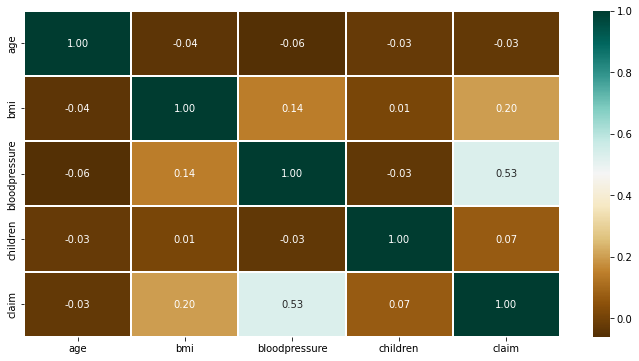

In [17]:
plt.figure(figsize=(12, 6))
sns.heatmap(df.corr(),
			cmap = 'BrBG',
			fmt = '.2f',
			linewidths = 2,
			annot = True)

1. Bloodpressure has strongest correlation score to claim cost and BMI has the second strongest correlation score to claim cost.
2. Age and children have weakest correlation score to claim cost even age has negative correlation.

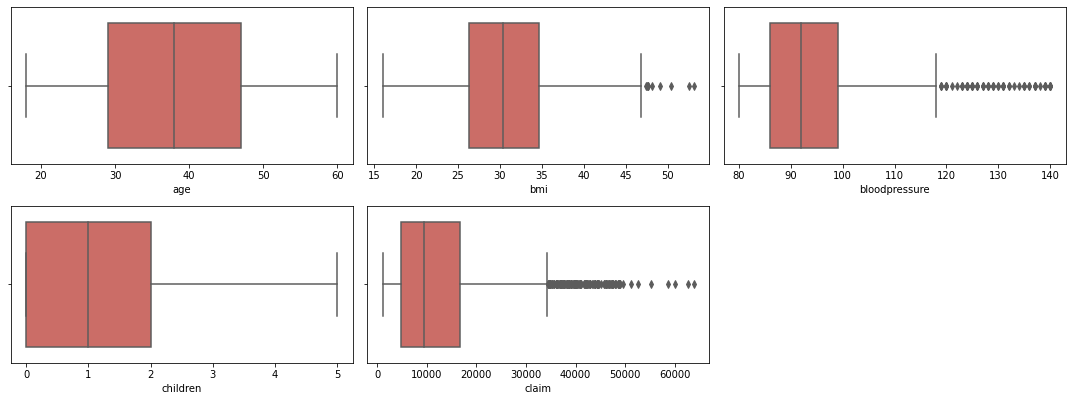

In [18]:
plt.figure(figsize = (15, 8))
number = 1
row = 3
for i in numeric_columns:
    plt.subplot(row, 3, number)
    sns.boxplot(x=i, data=df, palette="hls")
    number += 1
    plt.tight_layout()

There are outliers in bmi, bloodpressure, and claim columns. I should delete them later because machine learning is less accurate if there are still have outliers in dataset.

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

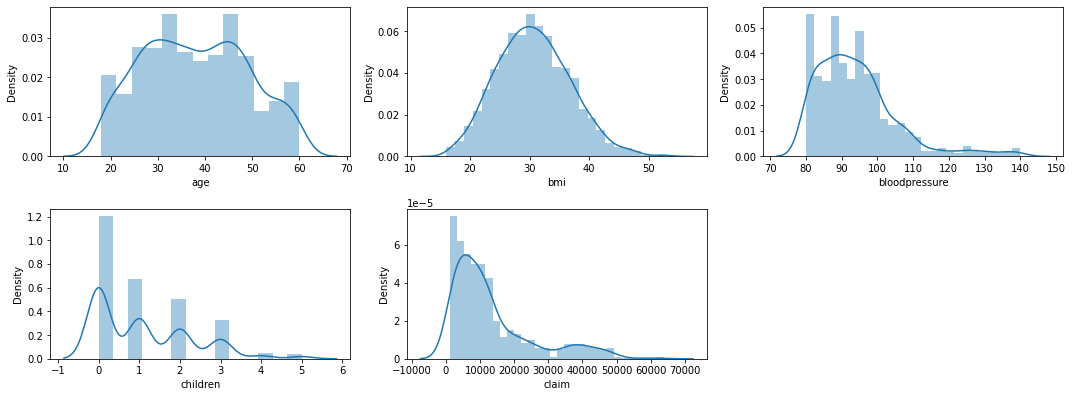

In [19]:
plt.figure(figsize = (15, 8))
number = 1
row = 3
for i in numeric_columns:
    plt.subplot(row, 3, number)
    sns.distplot(df[i])
    number += 1
    plt.tight_layout()

In [20]:
for i in numeric_columns:
    x = df[i].mean()
    y = df[i].median()
    z = df[i].mode()
    
    a = pd.DataFrame({'mean': x, 'median': y, 'mode': z})
    print(i)
    print(a)
    print("_"*15)

age
        mean  median  mode
0  38.078652    38.0  43.0
_______________
bmi
        mean  median  mode
0  30.668955    30.4  27.6
1  30.668955    30.4  33.3
_______________
bloodpressure
        mean  median  mode
0  94.157463    92.0    91
_______________
children
       mean  median  mode
0  1.093284     1.0     0
_______________
claim
           mean    median     mode
0  13252.745642  9369.615  1149.40
1  13252.745642  9369.615  1639.56
2  13252.745642  9369.615  1704.57
_______________


Age, BMI, and blood pressure columns have normal distribution

Note: I still learn about data distribution so correct me if I'm wrong.

In [21]:
numeric_columns.describe().T

,count,mean,std,min,25%,50%,75%,max
age,1340.0,38.078652,11.082175,18.00,29.000,38.000,47.000,60.00
bmi,1340.0,30.668955,6.106735,16.00,26.275,30.400,34.700,53.10
bloodpressure,1340.0,94.157463,11.434712,80.00,86.000,92.000,99.000,140.00
children,1340.0,1.093284,1.205334,0.00,0.000,1.000,2.000,5.00
claim,1340.0,13252.745642,12109.609288,1121.87,4719.685,9369.615,16604.305,63770.43


In [22]:
df.describe(include="object").T

,count,unique,top,freq
gender,1340,2,male,678
diabetic,1340,2,No,698
smoker,1340,2,No,1066
region,1340,4,southeast,446


1. The most people who claim their insurance based from gender is male
2. The most people who claim their insurance based on diabetic suffer is people who doesn't diabetic suffer.
3. The most people who claim their insurance is non-smoker
4. The most people who claim their insurance is from Southeast.

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn

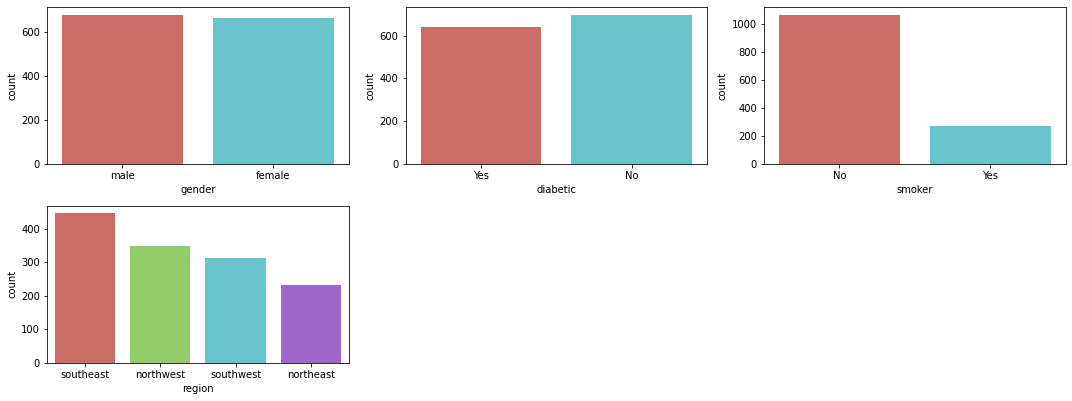

In [23]:
plt.figure(figsize = (15, 8))
number = 1
row = 3
for i in categoric_columns:
    plt.subplot(row, 3, number)
    sns.countplot(df[i], palette="hls")
    number += 1
    plt.tight_layout()

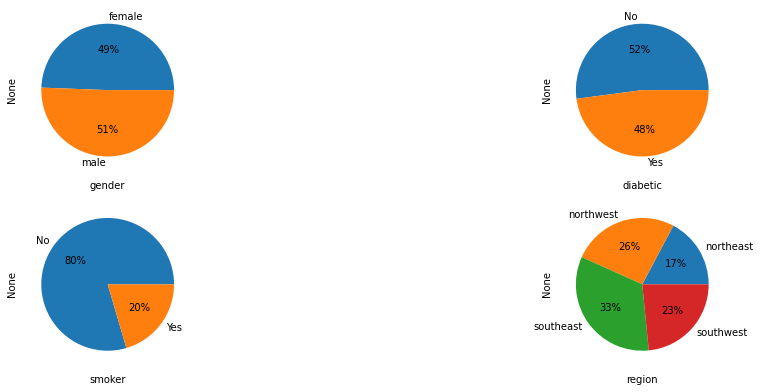

In [24]:
plt.figure(figsize = (15, 8))
number = 1
row = 3
for i in categoric_columns:
    plt.subplot(row, 2, number)
    df.groupby(i).size().plot(kind='pie', autopct='%.0f%%')
    plt.xlabel(i)
    number += 1
    plt.tight_layout()

#df.groupby('region').size().plot(kind='pie', autopct='%.2f')

**Conclusion:**
1. Average of insurer who claim their insurance is 38 years old.
2. Average amount of insurance claim cost is 13.252
3. Insurance claim is dominated by 80% of non-smoker meanwhile smoker who claim their insurance is only 20%.
4. The most region of people who claim their insurance is from Southeast (33%). Followed by Northwest, Southwest, and Northeast in a row.
5. Difference or comparison of gender and diabetic suffer from people who claim their insurance is almost the same.
6. BMI average of people who claim insurance is 30.
7. Blood pressure average of people who claim their insurance is 94.
8. Average of people who claims their insurance at least have one children.

# Delete Outliers

In [25]:
#data train
print(f'Rows amount before delete outliers: {len(df)}')

filtered_entries = np.array([True] * len(df))
for col in ['age', 'bmi', 'bloodpressure', 'children', 'claim']:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    low_limit = Q1 - (IQR * 1.5)
    high_limit = Q3 + (IQR * 1.5)

    filtered_entries = ((df[col] >= low_limit) & (df[col] <= high_limit)) & filtered_entries
    
df_without_outliers = df[filtered_entries]

print(f'Rows amount after delete outliers: {len(df_without_outliers)}')

Rows amount before delete outliers: 1340
Rows amount after delete outliers: 1176


In [26]:
numeric_columns.columns

Index(['age', 'bmi', 'bloodpressure', 'children', 'claim'], dtype='object')

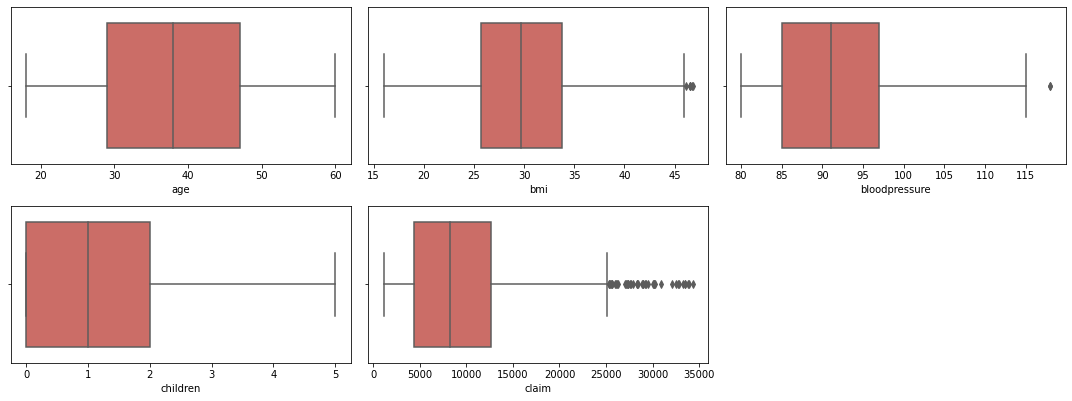

In [27]:
plt.figure(figsize = (15, 8))
number = 1
row = 3
for i in ['age', 'bmi', 'bloodpressure', 'children', 'claim']:
    plt.subplot(row, 3, number)
    sns.boxplot(x=i, data=df_without_outliers, palette="hls")
    number += 1
    plt.tight_layout()

# Standarization of Numeric Data

In [28]:
from sklearn.preprocessing import StandardScaler

In [29]:
list_of_numeric_columns = ['age', 'bmi', 'bloodpressure', 'children', 'claim']

In [30]:
df[list_of_numeric_columns].describe().T

,count,mean,std,min,25%,50%,75%,max
age,1340.0,38.078652,11.082175,18.00,29.000,38.000,47.000,60.00
bmi,1340.0,30.668955,6.106735,16.00,26.275,30.400,34.700,53.10
bloodpressure,1340.0,94.157463,11.434712,80.00,86.000,92.000,99.000,140.00
children,1340.0,1.093284,1.205334,0.00,0.000,1.000,2.000,5.00
claim,1340.0,13252.745642,12109.609288,1121.87,4719.685,9369.615,16604.305,63770.43


In [31]:
#numeric_columns_list = numeric_columns.columns.tolist()

In [32]:
df_std = StandardScaler().fit_transform(df_without_outliers[list_of_numeric_columns])

df_std = pd.DataFrame(data=df_std, index=df_without_outliers.index, columns=df_without_outliers[list_of_numeric_columns].columns)

In [33]:
df_std.head()

,age,bmi,bloodpressure,children,claim
0,0.068554,-1.153643,-0.100307,-0.896019,-1.240921
1,-1.281697,0.017009,-0.606577,-0.896019,-1.239511
2,-0.014383,0.559920,-1.239414,-0.896019,-1.238864
3,-0.014383,0.627784,-1.492549,-0.896019,-1.238796
4,-0.014383,0.695648,1.038800,-0.896019,-1.238707


In [34]:
df_std.describe().T

,count,mean,std,min,25%,50%,75%,max
age,1176.0,-1.555823e-16,1.000425,-1.821798,-0.831613,-0.021463,0.788688,1.958906
bmi,1176.0,2.265761e-16,1.000425,-2.375192,-0.729493,-0.050855,0.644750,2.850326
bloodpressure,1176.0,-5.800349e-16,1.000425,-1.492549,-0.859711,-0.100307,0.659098,3.317014
children,1176.0,-1.208406e-17,1.000425,-0.896019,-0.896019,-0.076005,0.744010,3.204053
claim,1176.0,-2.416812e-16,1.000425,-1.240921,-0.768959,-0.196837,0.444394,3.612011


In [35]:
#merge df_std and categoric_columns
#df_categoric = df_without_outliers.select_dtypes(include = ["object"])
#df_categoric = categoric_columns.copy() #declare new variable
#df_after_merge = df_std.merge(df_categoric, left_index = True, right_index=True, how= 'left')
#df_after_merge

# Label Encode for Categoric Data

In [36]:
from sklearn.preprocessing import LabelEncoder

In [37]:
list_of_categoric_columns = df_without_outliers.select_dtypes(include = "object").columns.tolist()
list_of_categoric_columns

['gender', 'diabetic', 'smoker', 'region']

In [38]:
df_encode = df_without_outliers[list_of_categoric_columns].copy()

In [39]:
for col in list_of_categoric_columns:
    df_encode[col] = LabelEncoder().fit_transform(df_encode[col])

In [40]:
df_encode

,gender,diabetic,smoker,region
0,1,1,0,2
1,1,0,0,2
2,1,1,0,2
3,1,0,0,1
4,1,0,0,1
...,...,...,...,...
1190,0,1,0,1
1191,1,0,1,0
1193,1,1,1,1
1195,0,0,1,1


Merge df_std with df_encode!

In [41]:
df_final = df_std.merge(df_encode, left_index=True, right_index=True, how="left")
df_final

,age,bmi,bloodpressure,children,claim,gender,diabetic,smoker,region
0,0.068554,-1.153643,-0.100307,-0.896019,-1.240921,1,1,0,2
1,-1.281697,0.017009,-0.606577,-0.896019,-1.239511,1,0,0,2
2,-0.014383,0.559920,-1.239414,-0.896019,-1.238864,1,1,0,2
3,-0.014383,0.627784,-1.492549,-0.896019,-1.238796,1,0,0,1
4,-0.014383,0.695648,1.038800,-0.896019,-1.238707,1,0,0,1
...,...,...,...,...,...,...,...,...,...
1190,-0.831613,1.272491,1.798205,0.744010,3.490444,0,1,0,1
1191,-0.831613,0.118805,0.279395,-0.896019,3.491007,1,0,1,0
1193,0.698671,0.322397,-1.239414,-0.896019,3.531149,1,1,1,1
1195,1.868889,0.067907,-1.492549,-0.896019,3.554149,0,0,1,1


Finally dataset is ready to modelling with machine learning!

# Modelling

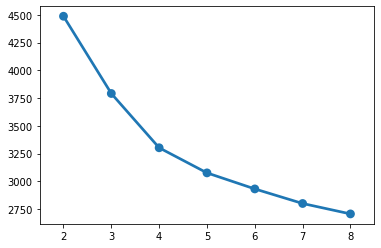

In [42]:
cost = {}  
for k in range(2,9):  
    kproto = KPrototypes(n_clusters = k,random_state=75)  
    kproto.fit_predict(df_final, categorical=[0,1,2])  
    cost[k]= kproto.cost_  
  
#Visualization of Elbow Plot   
sns.pointplot(x=list(cost.keys()), y=list(cost.values()))  
plt.show()

I choose k = 4. It means I'll make four cluster of dataset df_final.

In [43]:
#Modelling
kproto = KPrototypes(n_clusters = 4, random_state = 75)  
kproto = kproto.fit(df_final, categorical=[0,1,2])  
  
#Save Model  
pickle.dump(kproto, open('cluster.pkl', 'wb'))  

In [44]:
#Define clusters each insurance claim
clusters =  kproto.predict(df_final, categorical=[0,1,2])    
print('Insurance claim segment: {}\n'.format(clusters)) 

Insurance claim segment: [1 1 1 ... 2 2 2]



In [45]:
df2 = df_without_outliers.copy()
df2["clusters"] = clusters
df2

,age,gender,bmi,bloodpressure,diabetic,children,smoker,region,claim,clusters
0,39.000000,male,23.2,91,Yes,0,No,southeast,1121.87,1
1,24.000000,male,30.1,87,No,0,No,southeast,1131.51,1
2,38.078652,male,33.3,82,Yes,0,No,southeast,1135.94,1
3,38.078652,male,33.7,80,No,0,No,northwest,1136.40,0
4,38.078652,male,34.1,100,No,0,No,northwest,1137.01,0
...,...,...,...,...,...,...,...,...,...,...
1190,29.000000,female,37.5,106,Yes,2,No,northwest,33471.97,2
1191,29.000000,male,30.7,94,No,0,Yes,northeast,33475.82,2
1193,46.000000,male,31.9,82,Yes,0,Yes,northwest,33750.29,2
1195,59.000000,female,30.4,80,No,0,Yes,northwest,33907.55,2


In [46]:
for i in range(0,4):
    print("Insurer cluster: ", i)
    print(df2[df2["clusters"] == i])

Insurer cluster:  0
            age  gender   bmi  bloodpressure diabetic  children smoker  \
3     38.078652    male  33.7             80       No         0     No   
4     38.078652    male  34.1            100       No         0     No   
5     38.078652    male  34.4             96      Yes         0     No   
6     38.078652    male  37.3             86      Yes         0     No   
7     19.000000    male  41.1            100       No         0     No   
...         ...     ...   ...            ...      ...       ...    ...   
988   46.000000    male  25.2            104      Yes         0    Yes   
996   29.000000  female  21.9             92      Yes         0    Yes   
997   30.000000    male  22.9            108       No         0    Yes   
1007  45.000000  female  30.6             85       No         1     No   
1023  51.000000  female  41.3             98       No         0     No   

         region     claim  clusters  
3     northwest   1136.40         0  
4     northwest

In [47]:
#df2[df2["clusters"] == 3]

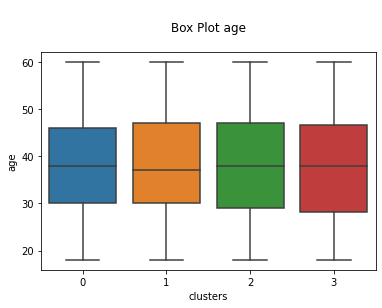

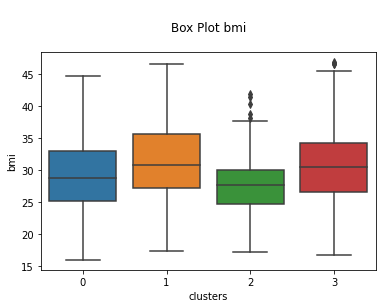

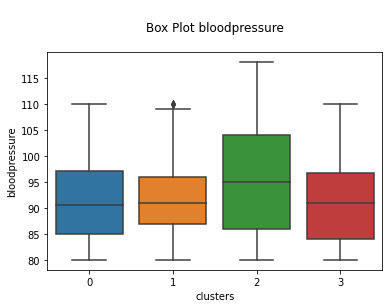

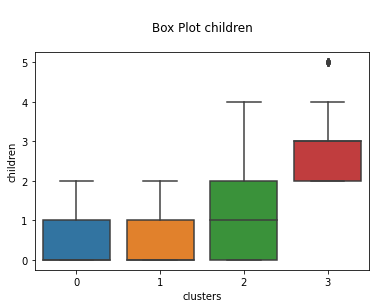

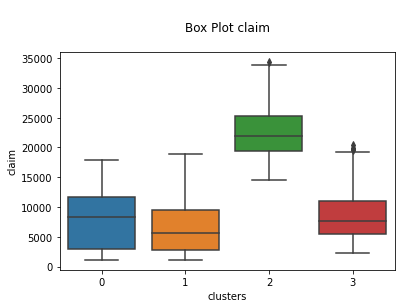

In [48]:
for i in list_of_numeric_columns:  
    plt.figure(figsize=(6,4))  
    ax = sns.boxplot(x = 'clusters',y = i, data = df2)  
    plt.title('\nBox Plot {}\n'.format(i), fontsize=12)  
    plt.show()

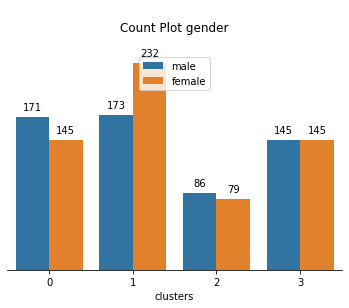

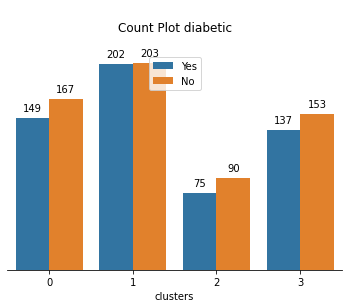

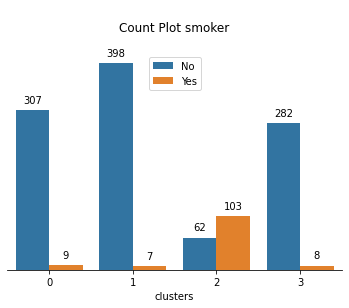

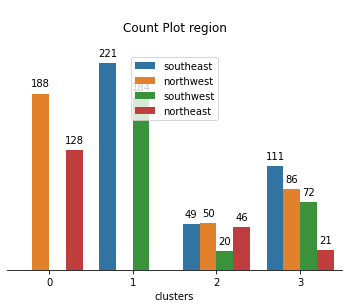

In [49]:
for i in list_of_categoric_columns:  
    plt.figure(figsize=(6,4))  
    ax = sns.countplot(data = df2, x = 'clusters', hue = i )  
    plt.title('\nCount Plot {}\n'.format(i), fontsize=12)  
    ax.legend(loc="upper center")  
    for p in ax.patches:  
        ax.annotate(format(p.get_height(), '.0f'),  
                    (p.get_x() + p.get_width() / 2., p.get_height()),  
                     ha = 'center',  
                     va = 'center',  
                     xytext = (0, 10),  
                     textcoords = 'offset points')  
      
    sns.despine(right=True,top = True, left = True)  
    ax.axes.yaxis.set_visible(False)  
    plt.show() 

In [50]:
df2[df2["clusters"]==3].describe().T

,count,mean,std,min,25%,50%,75%,max
age,290.0,37.755172,11.240624,18.0,28.250,38.00,46.7500,60.0
bmi,290.0,30.630690,6.057229,16.8,26.550,30.40,34.1750,46.8
bloodpressure,290.0,90.858621,7.450692,80.0,84.000,91.00,96.7500,110.0
children,290.0,2.744828,0.842466,2.0,2.000,3.00,3.0000,5.0
claim,290.0,8578.494897,3918.629500,2304.0,5467.625,7728.25,11072.6075,20463.0
clusters,290.0,3.000000,0.000000,3.0,3.000,3.00,3.0000,3.0


# Conclusion:
1. Cluster 0 has insurance claim cost in range 1100 to 18000. Cluster 0 is people who life in Northeast or Northwest. They are dominated mostly by non-smoker.
2. Cluster 1 has insurance claim cost in range 1100 to 19000. Cluster 1 is people who life in Southeast or Southwest. They are dominated mostly by non-smoker.
3. Cluster 2 has insurance claim cost in range 14000 to 35000. Cluster 2 is people who life in Souteast, Southwest, Northeast, or Northwest
4. Cluster 3 has insurance claim cost in range 2000 to 21000. Cluster 3 is people who life in Souteast, Southwest, Northeast, or Northwest. They are dominated mostly by non-smoker.

# Weakness
This is my own opinion about lack of my work:
1. Cluster 0 and 1 are almost same! Their difference is only on region.
2. index and PatientID are not contains in dataset df2 so I can't define each patient's cluster.

Thank you for read this notebook! Please give me some advices and suggestion about my work because I'm beginner. Thank you!